***

<font color='green'>

# Project Solution: GL Chatbot - Part 2

### Context: Great Learning is looking forward to design an automation which can interact with the user, understand the problem and display the resolution procedure [if found as a generic request] or redirect the request to an actual human support executive if the request is complex or not in it’s database. This is to support Academic Support department of Great Learning.

### Objective: Design a Python based interactive semi-rule based chatbot which can do the following:
1. Start chat session with greetings and ask what the user is looking for.
2. Accept dynamic text based questions from the user. Reply back with relevant answer from the designed corpus.
3. End the chat session only if the user requests to end else ask what the user is looking for. Loop continues till the user asks to end it.
    
### Section 1: This module involves ONLY the modelling part that will be used to build the chatbot in Section 2
#### Input: GL Bot.json containing a designed corpus with tags, patterns, responses

***
***
*Prepared by: Sauvik De*

*Date: September 4, 2021*

</font>

##### Reference: https://www.mygreatlearning.com/blog/basics-of-building-an-artificial-intelligence-chatbot
***

In [1]:
import nltk, json

In [2]:
with open('GL Bot.json') as f:
    corpus = json.load(f)

In [3]:
# Extract data
WORDS = []  #Tokens
LABELS = [] #Identified tags or labels
doc_X = []  #Tokenized words
doc_y = []  #Tags or Labels

for intents in corpus['intents']:
    for pattern in intents['patterns']:
        w = nltk.word_tokenize(pattern)
        WORDS.extend(w)  #Bag of Words
        doc_X.append(w)  #Maintain tokenized words with orders intact
        doc_y.append(intents['tag'])

    # Add the missing tag if any
    if intents['tag'] not in LABELS:
        LABELS.append(intents['tag'])

In [4]:
lemmatizer = nltk.stem.WordNetLemmatizer()
tag_dict = {"J": 'a', #nltk.corpus.wordnet.ADJ,
            "N": 'n', #nltk.corpus.wordnet.NOUN,
            "V": 'v', #nltk.corpus.wordnet.VERB,
            "R": 'r'  #nltk.corpus.wordnet.ADV
           }

def get_wordnet_pos(word):
   pTag = nltk.pos_tag([word])[0][1][0].upper()
   return tag_dict.get(pTag, 'n') 

WORDS = [lemmatizer.lemmatize(w, pos=get_wordnet_pos(w)).lower() for w in WORDS if w != '?']
WORDS = sorted(list(set(WORDS))) #Fetch unique list of words

In [5]:
# Prepare dataset for model building
X = []
y = []

for i, doc in enumerate(doc_X):
    bow = []
    w_doc = [lemmatizer.lemmatize(w, pos=get_wordnet_pos(w.lower())) for w in doc]
    
    for w in WORDS:
        if w in w_doc:
            bow.append(1)
        else: bow.append(0)
    
    out = [0]*len(LABELS)
    out[LABELS.index(doc_y[i])] = 1

    X.append(bow)
    y.append(out) #One-Hot-encode target (tags)

#### Use Neural Network model to predict tags

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

In [7]:
n_classes = len(y[0])

model = Sequential()
model.add(Dense(32, input_dim=len(X[0]), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(n_classes, activation='softmax'))

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                6304      
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [11]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, mode='min')

In [12]:
hist = model.fit(X_train, y_train, epochs=500, batch_size=16, verbose=1, 
                 validation_data=(X_test, y_test), callbacks=[callback])

Epoch 1/500
10/10 [==============================] - 1s 24ms/step - loss: 2.7757 - accuracy: 0.1258 - val_loss: 2.0916 - val_accuracy: 0.1053
Epoch 2/500
10/10 [==============================] - 0s 5ms/step - loss: 2.8646 - accuracy: 0.1258 - val_loss: 2.0833 - val_accuracy: 0.0789
Epoch 3/500
10/10 [==============================] - 0s 5ms/step - loss: 2.5082 - accuracy: 0.1656 - val_loss: 2.0763 - val_accuracy: 0.0789
Epoch 4/500
10/10 [==============================] - 0s 5ms/step - loss: 2.3793 - accuracy: 0.1589 - val_loss: 2.0651 - val_accuracy: 0.0789
Epoch 5/500
10/10 [==============================] - 0s 6ms/step - loss: 2.2789 - accuracy: 0.1722 - val_loss: 2.0555 - val_accuracy: 0.1053
Epoch 6/500
10/10 [==============================] - 0s 6ms/step - loss: 2.2030 - accuracy: 0.2384 - val_loss: 2.0429 - val_accuracy: 0.1316
Epoch 7/500
10/10 [==============================] - 0s 6ms/step - loss: 2.3097 - accuracy: 0.1854 - val_loss: 2.0302 - val_accuracy: 0.1579
Epoch 8/500


10/10 [==============================] - 0s 5ms/step - loss: 0.8732 - accuracy: 0.7285 - val_loss: 0.9885 - val_accuracy: 0.7632
Epoch 59/500
10/10 [==============================] - 0s 4ms/step - loss: 0.9763 - accuracy: 0.6887 - val_loss: 0.9748 - val_accuracy: 0.7632
Epoch 60/500
10/10 [==============================] - 0s 5ms/step - loss: 0.8979 - accuracy: 0.6821 - val_loss: 0.9641 - val_accuracy: 0.7632
Epoch 61/500
10/10 [==============================] - 0s 5ms/step - loss: 0.8344 - accuracy: 0.7219 - val_loss: 0.9542 - val_accuracy: 0.7895
Epoch 62/500
10/10 [==============================] - 0s 5ms/step - loss: 0.8825 - accuracy: 0.7285 - val_loss: 0.9455 - val_accuracy: 0.8158
Epoch 63/500
10/10 [==============================] - 0s 5ms/step - loss: 0.9269 - accuracy: 0.6954 - val_loss: 0.9308 - val_accuracy: 0.8158
Epoch 64/500
10/10 [==============================] - 0s 5ms/step - loss: 0.9313 - accuracy: 0.7152 - val_loss: 0.9183 - val_accuracy: 0.8158
Epoch 65/500
10/10 

Epoch 116/500
10/10 [==============================] - 0s 5ms/step - loss: 0.5549 - accuracy: 0.8013 - val_loss: 0.7121 - val_accuracy: 0.7368
Epoch 117/500
10/10 [==============================] - 0s 5ms/step - loss: 0.5975 - accuracy: 0.8146 - val_loss: 0.7118 - val_accuracy: 0.7368
Epoch 118/500
10/10 [==============================] - 0s 4ms/step - loss: 0.6107 - accuracy: 0.7947 - val_loss: 0.7047 - val_accuracy: 0.7632
Epoch 119/500
10/10 [==============================] - 0s 4ms/step - loss: 0.5034 - accuracy: 0.8609 - val_loss: 0.6967 - val_accuracy: 0.7632
Epoch 120/500
10/10 [==============================] - 0s 5ms/step - loss: 0.5572 - accuracy: 0.8013 - val_loss: 0.6993 - val_accuracy: 0.7632
Epoch 121/500
10/10 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.7881 - val_loss: 0.6983 - val_accuracy: 0.7632
Epoch 122/500
10/10 [==============================] - 0s 5ms/step - loss: 0.5228 - accuracy: 0.8344 - val_loss: 0.7021 - val_accuracy: 0.7368

10/10 [==============================] - 0s 5ms/step - loss: 0.4615 - accuracy: 0.8543 - val_loss: 0.6188 - val_accuracy: 0.8421
Epoch 174/500
10/10 [==============================] - 0s 4ms/step - loss: 0.3638 - accuracy: 0.8675 - val_loss: 0.6171 - val_accuracy: 0.8421
Epoch 175/500
10/10 [==============================] - 0s 5ms/step - loss: 0.4152 - accuracy: 0.8609 - val_loss: 0.6125 - val_accuracy: 0.8421
Epoch 176/500
10/10 [==============================] - 0s 5ms/step - loss: 0.4065 - accuracy: 0.8808 - val_loss: 0.6121 - val_accuracy: 0.8421
Epoch 177/500
10/10 [==============================] - 0s 5ms/step - loss: 0.4070 - accuracy: 0.8609 - val_loss: 0.6224 - val_accuracy: 0.8421
Epoch 178/500
10/10 [==============================] - 0s 4ms/step - loss: 0.4708 - accuracy: 0.8344 - val_loss: 0.6141 - val_accuracy: 0.8421
Epoch 179/500
10/10 [==============================] - 0s 5ms/step - loss: 0.3661 - accuracy: 0.8874 - val_loss: 0.6197 - val_accuracy: 0.8421
Epoch 180/500

10/10 [==============================] - 0s 4ms/step - loss: 0.3038 - accuracy: 0.9139 - val_loss: 0.5278 - val_accuracy: 0.8421
Epoch 231/500
10/10 [==============================] - 0s 5ms/step - loss: 0.3260 - accuracy: 0.9073 - val_loss: 0.5328 - val_accuracy: 0.8421
Epoch 232/500
10/10 [==============================] - 0s 5ms/step - loss: 0.3247 - accuracy: 0.8940 - val_loss: 0.5329 - val_accuracy: 0.8421
Epoch 233/500
10/10 [==============================] - 0s 4ms/step - loss: 0.4009 - accuracy: 0.8609 - val_loss: 0.5348 - val_accuracy: 0.8421
Epoch 234/500
10/10 [==============================] - 0s 4ms/step - loss: 0.2700 - accuracy: 0.9007 - val_loss: 0.5453 - val_accuracy: 0.8421
Epoch 235/500
10/10 [==============================] - 0s 5ms/step - loss: 0.2811 - accuracy: 0.9007 - val_loss: 0.5447 - val_accuracy: 0.8421
Epoch 236/500
10/10 [==============================] - 0s 5ms/step - loss: 0.2718 - accuracy: 0.8940 - val_loss: 0.5394 - val_accuracy: 0.8421
Epoch 237/500

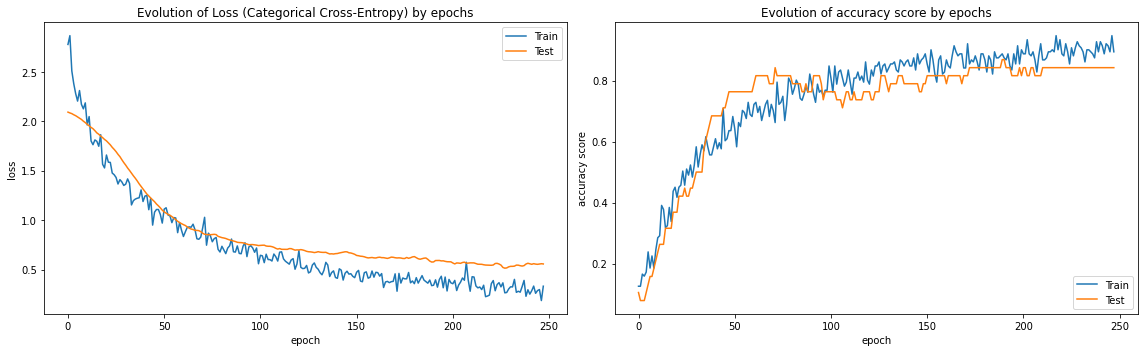

In [13]:
import matplotlib.pyplot as plt

# Performance evolution across epochs
plt.figure(figsize=(16,5))

# History of Loss
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Evolution of Loss (Categorical Cross-Entropy) by epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')

#-----------------

# History of accuracy score
plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Evolution of accuracy score by epochs')
plt.ylabel('accuracy score')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.tight_layout()

In [14]:
# serialize model to JSON
model_json = model.to_json()
with open("chatbotModel.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("chatbotModel.h5")
print("Saved model to disk")

Saved model to disk
